### Corrective RAG

In [1]:
import os
from dotenv import load_dotenv
load_dotenv() ## loading all the environment variable

groq_api_key=os.getenv("GROQ_API_KEY")
llm_model = os.getenv("LLM_MODEL")
embedding_model = os.getenv("EMBEDDING_MODEL")



In [2]:
### Build Index

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings


c:\Users\jaypr_ughx7yt\OneDrive\Desktop\Data Science Project working\AI Doctor\doctorenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load PDF
loader = PyPDFLoader('Medical_book.pdf')
docs = loader.load()   # returns a list of Document objects

In [4]:
# Split PDF into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200
)

doc_splits = text_splitter.split_documents(docs)

In [5]:

embed_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={'device': 'cpu'},   # or 'cuda'
    encode_kwargs={'normalize_embeddings': True}
)

In [6]:
# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embed_model
)

KeyboardInterrupt: 

In [11]:
 # Save locally
vectorstore.save_local('faiss_index')

In [7]:
vectorstore = FAISS.load_local(
            folder_path='faiss_index',
            embeddings=embed_model,
            allow_dangerous_deserialization=True
        )

In [8]:
retriever=vectorstore.as_retriever()

In [ ]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatGroq(groq_api_key = groq_api_key, model_name = llm_model)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
##chain the prompt with the LLM
retrieval_grader = grade_prompt | structured_llm_grader
question = "Abdominal wall defects"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [10]:
### Generate
from langchain_core.output_parsers import StrOutputParser

# Prompt

system_message = """You are an assistant for question-answering tasks.
Use the following retrieved context to answer the question.
If you don't know the answer, say 'I don't know'."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", "Retrieved document:\n\n{context}\n\nUser question:\n{question}")
    ]
)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

Abdominal wall defects are birth (congenital) defects that allow the stomach or intestines to protrude. They are caused by the failure of the abdominal wall to close properly during fetal development, resulting in the stomach or intestines being outside of the abdomen.

Causes and symptoms of abdominal wall defects are not well understood, and any symptoms the mother may have to indicate that the defects are present in the fetus are nondescript. However, at birth, the problem is obvious, and an ultrasound examination may detect the problem before birth.

Abdominal wall defects are effectively treated with surgical repair, unless there are accompanying anomalies. The prognosis after surgical repair is relatively good, but 10% of those with more severe or additional abnormalities may die from it.


In [11]:
### Question Re-writer


# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Here\'s a re-written version of the question optimized for web search:\n\n"What are the causes, symptoms, and treatment options for abdominal wall defects, including hernias, diastasis recti, and other related conditions?"\n\nThis revised question:\n\n1. Adds specificity by mentioning related conditions (hernias and diastasis recti).\n2. Includes relevant keywords (causes, symptoms, treatment options) to improve search engine results.\n3. Provides a clear and concise description of the topic, making it easier for search engines to understand the user\'s intent.\n\nThis revised question should yield more accurate and relevant search results, providing a better understanding of abdominal wall defects and related conditions.'

In [12]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [17]:
# from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            transform_query_required = "Yes"
            
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}





### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [18]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "grade_documents")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

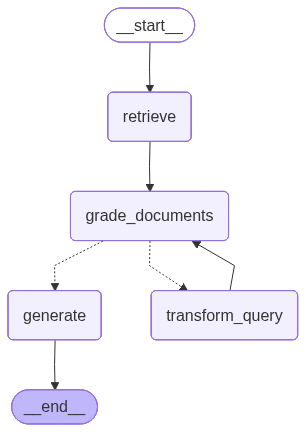

In [19]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [21]:
app.invoke({"question":"Abdominal wall defects"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


{'question': 'Abdominal wall defects',
 'generation': 'Based on the retrieved document, I can provide information about abdominal wall defects. \n\nAbdominal wall defects are birth (congenital) defects that allow the stomach or intestines to protrude. They occur when the abdominal wall does not develop properly, and the stomach or intestines may bulge or protrude outside the abdomen.\n\nCauses and symptoms:\n\n* The cause(s) of abdominal wall defects is unknown.\n* Symptoms in the mother may be non-descript.\n* At birth, the problem is obvious, as the base of the umbilical cord at the navel will bulge or may contain viscera (internal organs).\n* An ultrasound examination may detect the problem before birth.\n\nDiagnosis and treatment:\n\n* Diagnosis can be made at birth or through an ultrasound examination before birth.\n* Treatment is surgical repair, which is effective unless there are accompanying anomalies.\n* The organs themselves are normal, just misplaced, but may be difficult t

In [1]:
from src.Vectorstore_Builder.faiss_store import FAISSStore

from src.Vectorstore_Builder.hf_embedding import HFEmbedding

c:\Users\jaypr_ughx7yt\OneDrive\Desktop\Data Science Project working\AI Doctor\doctorenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embedding_loader = HFEmbedding()
embedding_model = embedding_loader.load()


# vectordb =  IndexBuilder("Medical_book.pdf").build_index()

faiss_store = FAISSStore(embedding_model, index_path="faiss_index")
vectordb = faiss_store.load()

retriever = faiss_store.get_retriever(vectordb)

question = "Abdominal wall defects"
docs = retriever.invoke(question)
print(docs)

✔ FAISS index loaded from: faiss_index


AssertionError: 